In [1]:
## to run change the inference file output last line 

In [2]:
import torch
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
from matplotlib import patches
import torch.nn as nn
from models.baselines.mulsa.inference import MULSAInference
from models.baselines.mulsa.src.datasets.imi_datasets import ImitationEpisode
from models.baselines.mulsa.src.models.encoders import (
    make_vision_encoder,
    make_audio_encoder,
)
from models.baselines.mulsa.src.models.imi_models import Actor
from models.baselines.mulsa.src.engines.engine import ImiEngine
import numpy as np
import os
import yaml
from torch.utils.data import DataLoader

In [3]:
config_path = '/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/conf/imi/train.yaml'
with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/mulsa_unimodal_simple_task_103-31-18:34:39/03-31-18:34:39-v1.ckpt"

# v_encoder = make_vision_encoder(config['encoder_dim'])
# a_encoder = make_audio_encoder(config['encoder_dim'] * config['num_stack'], config['norm_audio'])

# model = Actor(v_encoder, a_encoder, config)
# model.load_state_dict(model_path)

model = MULSAInference.load_from_checkpoint(model_path).cuda()
# model.eval()

# feature_extractor_model = nn.Sequential(*list(model.children())[:-1])
# model = feature_extractor_model.to('cuda')

model.eval()

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.2.0.post0
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/tor

MULSAInference(
  (actor): Actor(
    (v_encoder): Encoder(
      (feature_extractor): ResNet(
        (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Module(
          (0): Module(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Module(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [5]:

        
np.random.seed(0)
run_ids = os.listdir(config['dataset_root'])
np.random.permutation(run_ids)
split = int(config['train_val_split']*len(run_ids))
train_episodes = run_ids[:split]
val_episodes = run_ids[split:]

print("Train episodes: ", len(train_episodes))
print("Val episodes: ", len(val_episodes))

train_set = torch.utils.data.ConcatDataset(
    [
        ImitationEpisode(config, run_id)
        for run_id in train_episodes
    ]
)
val_set = torch.utils.data.ConcatDataset(
    [
        ImitationEpisode(config, run_id, train=False)
        for run_id in val_episodes
    ]
)

train_loader = DataLoader(train_set, config["batch_size"], num_workers=config["num_workers"])
val_loader = DataLoader(val_set, num_workers=config["num_workers"], shuffle=False,batch_size=1)

Train episodes:  80
Val episodes:  20


In [6]:
outputs_list = []
targets_list = []
indices = []

for i, (img, target) in enumerate(val_loader):
    # print(i, (img[0].shape), (img[1][0].shape), target.shape)
    # img[0] = [element[-1, :].cuda() for element in img[0]]
    img[0] = img[0][-1]
    # img[1] = img[1].cuda()
    # target = target[:,-1,:]
    # print(i, (img[0][0].shape), (img[1][0].shape), target.shape)
    if i > 999:
        break
    with torch.no_grad():
        _, _, output  = model(img)
    outputs_list.append(output)
    targets_list.append(target)
    indices.append(i)

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change fro

TypeError: list indices must be integers or slices, not str

In [ ]:

outputs = torch.cat(outputs_list, dim=0)
targets = torch.cat(targets_list, dim=0)

In [ ]:
outputs.shape, targets.shape

(torch.Size([1000, 1536]), torch.Size([1000, 11]))

In [ ]:
outputs = outputs.view(outputs.size(0), -1).cpu().numpy()
targets = targets.cpu().numpy()

In [ ]:
outputs.shape, targets.shape

((1000, 1536), (1000, 11))

In [ ]:
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(outputs)
features_tsne.shape

(1000, 2)

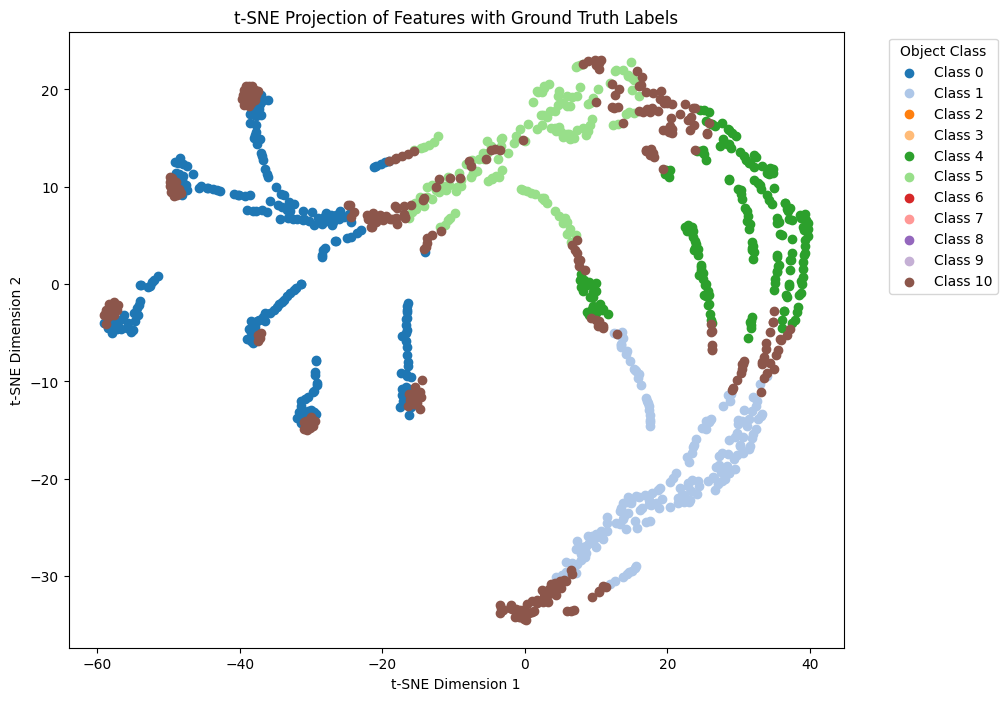

In [ ]:
class_colors = plt.cm.tab20(np.arange(11))

plt.figure(figsize=(10, 8))
for i in range(11):
    indices = np.where(targets[:, i] == 1)[0]
    plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], label=f"Class {i}", color=class_colors[i])

plt.title('t-SNE Projection of Features with Ground Truth Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Object Class', bbox_to_anchor=(1.05, 1), loc='upper left')  